# Object Detection for Cars

## Overview

Object recognition is the linchpin for self-driving cars and traffic safety cameras. It enables self-driving cars to identify and respond to objects like pedestrians and vehicles in real-time, ensuring safer autonomous driving. Additionally, it helps traffic safety cameras monitor and enforce traffic rules, enhancing road safety and efficiency. This notebook will walk through three object detection models that can identify and draw bounding-boxes around cars on the road: YOLOv8, R-CNN, and Bounding Box Regression (BB). The YOLOv8 model was implemented with the pre-packaged model from Ultralytics, and R-CNN and BB were built from the ground up. We will walk through differences between each model on a conceptual level, their implementation and respective evaluation scores. 

## The Data

The data was taken from a kaggle dataset consisting of roughly a thousand street view images divided into test and training sets. Some of these images consisted of cars and others did not. The dataset also included bounding box informations associated with each image. There were no labels for this dataset as there was only one class of object, a car. 

To download this dataset visit the following link: https://www.kaggle.com/datasets/sshikamaru/car-object-detection

## Data Preparation

In the notebook, the following preprocessing steps have been applied to each of the models:

For YOLOv8:
The input images were resized or padded to a fixed size (e.g., 416x416 pixels).
Pixel values were normalized for consistent scaling.
The bounding box information from the dataset was reorganized into yaml files for the yolo algorithm to process.

Regarding R-CNN:
Region proposals were generated, employing methods like selective search.
Each proposal was cropped and resized to match the model's input size.
Pixel values were normalized to maintain data uniformity.

Concerning Bounding Box Regression:
It was assumed that objects were already localized within the input images.
Optional adjustments to bounding box coordinates were made when necessary.
Bounding box coordinates or relevant features were normalized as required.
These preprocessing steps ensure that the data is suitably prepared for each model within the notebook.

## Modeling

In this notebook, there are three models for car detection: YOLOv8, R-CNN, and Bounding Box Regression.

YOLOv8 (You Only Look Once):
YOLOv8 is an efficient real-time object detection model. It divides the input image into a grid and predicts bounding boxes and class probabilities for objects within each grid cell. YOLOv8 uses a single neural network to simultaneously predict bounding boxes and class labels, making it fast and accurate. It operates by regressing bounding box coordinates and class probabilities directly from the image features.

R-CNN (Region-based Convolutional Neural Network):
R-CNN is a two-step object detection approach. It first generates region proposals from the image using a selective search or similar method. Then, each region proposal is individually passed through a CNN to extract features. These features are then used to classify and refine the bounding box of the detected object. R-CNNs are accurate but computationally expensive due to the two-stage process.

Bounding Box Regression:
Bounding Box Regression is a simple technique that involves training a model to predict adjustments to the coordinates of bounding boxes. Initially, a bounding box is defined around an object's region. The model then learns to predict corrections to the box's coordinates, refining its position and size. This model however is limited because it can only predict one bounding box in an image that should contain multiple vehicles. 

## Imports

In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mimetypes
import argparse
import imutils
import cv2
import os

In [13]:
path = "data/training_images/"
annot = "annotations"

In [14]:
images = []
targets = []
filenames = []

In [15]:
for e,i in enumerate(os.listdir(annot)):
    filename = i.split(".")[0]+".jpg"
    # print(filename)
    img = cv2.imread(os.path.join(path,filename))
    df = pd.read_csv(os.path.join(annot,i))
    (h,w) = img.shape[:2]
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        x1_norm = float(x1) / w
        y1 = int(row[1][0].split(" ")[1])
        y1_norm = float(y1) / h
        x2 = int(row[1][0].split(" ")[2])
        x2_norm = float(x2) / w
        y2 = int(row[1][0].split(" ")[3])
        y2_norm = float(y2) / h
        break
    img = load_img(os.path.join(path,filename), target_size=(224, 224))
    img = img_to_array(img)
    images.append(img)
    targets.append((x1_norm, y1_norm, x2_norm, y2_norm))
    filenames.append(filename)

In [16]:
images = np.array(images, dtype='float32')/255.0
targets = np.array(targets, dtype='float32')
split = train_test_split(images, targets, filenames, test_size=0.2)
trainImages, testImages = split[:2]
trainTargets, testTargets = split[2:4]
trainFilenames, testFilenames = split[4:]

In [17]:
print("[INFO] saving testing filenames...")
f = open('saved_imagestxt_reg/test_images.txt', "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving testing filenames...


In [18]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid")(bboxHead)
# construct the model we will fine-tune for bounding box regression
model = Model(inputs=vgg.input, outputs=bboxHead)

In [31]:
model.compile(loss="mse", metrics=["accuracy"], optimizer=Adam(lr=0.025))
print(model.summary())
# train the network for bounding box regression
print("[INFO] training bounding box regressor...")
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
H = model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets), batch_size=32, epochs=25, verbose=1, callbacks=[checkpoint,early])
#add map score


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Epoch 1/25
9/9 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.7077
Epoch 1: val_loss improved from inf to 0.02965, saving model to ieeercnn_vgg16_1.h5


/Users/nicholastjandra/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 50s 6s/step - loss: 0.0416 - accuracy: 0.7077 - val_loss: 0.0296 - val_accuracy: 0.3099
Epoch 2/25
9/9 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.7430
Epoch 2: val_loss improved from 0.02965 to 0.02396, saving model to ieeercnn_vgg16_1.h5
9/9 [==============================] - 58s 7s/step - loss: 0.0109 - accuracy: 0.7430 - val_loss: 0.0240 - val_accuracy: 0.5775
Epoch 3/25
9/9 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9120
Epoch 3: val_loss improved from 0.02396 to 0.01842, saving model to ieeercnn_vgg16_1.h5
9/9 [==============================] - 57s 7s/step - loss: 0.0067 - accuracy: 0.9120 - val_loss: 0.0184 - val_accuracy: 0.7606
Epoch 4/25
9/9 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9049
Epoch 4: val_loss improved from 0.01842 to 0.01612, saving model to ieeercnn_vgg16_1.h5
9/9 [==============================] - 56s 6s/step - loss: 0.0044 - accuracy: 0

In [20]:
print("[INFO] saving object detector model...")
model.save('saved_models_reg/detector.f5', save_format="h5")

[INFO] saving object detector model...


In [22]:
# N = 25
# plt.figure()
# plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
# plt.title("Bounding Box Regression Loss on Training Set")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss")
# plt.legend(loc="lower left")
# plt.savefig('saved_figures_reg/plot.png')

In [ ]:
# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--input", required=True,
# 	help="saved_imagestxt_reg/test_images.txt")
# args = vars(ap.parse_args())
# # determine the input file type, but assume that we're working with
# # single input image
# filetype = mimetypes.guess_type(args["input"])[0]
# imagePaths = [args["input"]]
# # if the file type is a text file, then we need to process *multiple*
# # images
# if "text/plain" == filetype:
# 	# load the filenames in our testing file and initialize our list
# 	# of image paths
# 	filenames = open(args["input"]).read().strip().split("\n")
# 	imagePaths = []
# 	# loop over the filenames
# 	for f in filenames:
# 		# construct the full path to the image filename and then
# 		# update our image paths list
# 		p = os.path.sep.join(['data/training_images/', f])
# 		imagePaths.append(p)

usage: ipykernel_launcher.py [-h] -i INPUT
ipykernel_launcher.py: error: the following arguments are required: -i/--input


SystemExit: 2

/Users/nicholastjandra/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Evaluation

In [23]:
# load our trained bounding box regressor from disk
print("[INFO] loading object detector...")
model = load_model('saved_models_reg/detector.f5')
# loop over the images that we'll be testing using our bounding box
# regression model
# for imagePath in imagePaths:

	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]
image = load_img(f'{path}vid_4_920.jpg', target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

[INFO] loading object detector...


1/1 [==============================] - 0s 265ms/step


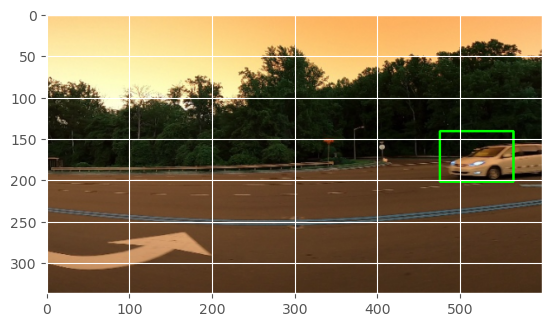

In [24]:
# make bounding box predictions on the input image
preds = model.predict(image)[0]
(startX, startY, endX, endY) = preds
# load the input image (in OpenCV format), resize it such that it
# fits on our screen, and grab its dimensions
image = cv2.imread(os.path.join(path,'vid_4_920.jpg'))
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
# draw the predicted bounding box on the image
cv2.rectangle(image, (startX, startY), (endX, endY),
    (0, 255, 0), 2)
# show the output image
plt.figure()

plt.imshow(image)

# cv2.imshow("Output", image)
# cv2.waitKey(0)